In [1]:
from keras.models import Sequential, load_model
from keras.layers import MaxPooling1D, Conv1D, Embedding, LSTM, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from keras import optimizers
from tensorflow import random as tf_random
import random

import pandas as pd
import os
import numpy as np
import re

Using TensorFlow backend.


In [2]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt

In [3]:
def normalize_signal(signal, min_max=False):
    """
    signal - np.array or pd.Series with signal values
    
    Returns normalized TS: (TS - mean(TS))/std(TS)
    """
    if signal.name == 'delta':
        return signal / 180
    if min_max:
        return (signal - signal.min()) / (signal.max() - signal.min())
    std = np.std(signal)
    norm_signal = (signal - np.mean(signal)) / std if std else 1
    return norm_signal

In [4]:
def normalize_all_signals_in_ds(one_group_ds, min_max=False):
    drop_cols = ['t'] if 't' in one_group_ds.columns else []
    for signal in one_group_ds.drop(drop_cols, axis=1):
        if signal in ['Ug', 'Pg']:
            one_group_ds[signal] = one_group_ds[signal] / one_group_ds[signal][0] - 1
        else:
            one_group_ds[signal] = normalize_signal(one_group_ds[signal], min_max)

In [5]:
oldpwd = os.getcwd()
print(oldpwd)

/home/poligon/master_degree


In [6]:
# os.chdir(oldpwd)
# os.chdir('..')
os.getcwd()

'/home/poligon/master_degree'

In [7]:
def append_signals_np_array(data_directory, signals_np_array = None, labels = None):
    drop_cols = ['Us', 'Pgt', 'Pij', 't']
    data_dir_list = os.listdir(data_directory)
    os.chdir(data_directory)
    if labels is None:
        signal_id = 0
        labels = pd.DataFrame(columns=['id', 'class', 'label'])
    else:
        signal_id = labels.id.max() + 1
    for signal_label, directory in enumerate(data_dir_list):
        if os.path.isfile(directory) or directory[0] == '.':
                continue
        os.chdir(directory)
        for filename in os.listdir(os.curdir):
            if re.match(r'(.*\.csv)', filename):
                if (signals_np_array) is not None:
                    tmp_ar = pd.read_csv(filename).drop(drop_cols, axis=1)
                    normalize_all_signals_in_ds(tmp_ar)
#                     print(tmp_ar.values.T.reshape(-1, 1))
                    signals_np_array = np.append(signals_np_array, tmp_ar.values.T.reshape(1, -1), axis=0)
                else:
                    signals_np_array = pd.read_csv(filename).drop(drop_cols, axis=1)
                    normalize_all_signals_in_ds(signals_np_array)
                    signals_np_array = signals_np_array.values.T.reshape(1, -1)
#                     print(signals_np_array)
#                 print(signals_dataset.head(5))
                tmp_labels = pd.Series([signal_id, directory, np.int(signal_label)],
                                         index=labels.columns)
                labels = labels.append(tmp_labels, ignore_index=True)
                signal_id += 1
        os.chdir('../')
    os.chdir('../..')
    return signals_np_array, labels

In [8]:
# Dataset for first gen
X_train, labels_train = append_signals_np_array('./data/gen_1_25')
X_train, labels_train = append_signals_np_array('./data/gen_3_25', X_train, labels_train)
# dataset, labels = append_signals_dataset('./data/gen_1_80', dataset, labels)
# Dataset for second gen
X_val, labels_val = append_signals_np_array('./data/gen_1_80')
X_val, labels_val = append_signals_np_array('./data/gen_2_80', X_val, labels_val)
X_val, labels_val = append_signals_np_array('./data/gen_3_80', X_val, labels_val)

In [9]:
# labelizer = LabelEncoder().fit(labels['class'])
def normalize_labels(labels_df):
    """
    Разметим все классы числами от 0 до количества классов
    и преобразуем новую колонку в формат чисел (float)
    """
    labels_df['label'] = labels_df['class'].replace({'le_8': 0,
                        'more_8': 1,
                        'more_20': 2,
                       })

In [10]:
print(X_train.shape, X_val.shape)

(101, 600) (171, 600)


In [11]:
normalize_labels(labels_train)
normalize_labels(labels_val)

In [12]:
Y_train = labels_train.label.values
Y_val = labels_val.label.values

In [13]:
# X & Y dims check
assert X_train.shape[0] == Y_train.shape[0]
assert X_val.shape[0] == Y_val.shape[0]

In [14]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_val, Y_val = shuffle(X_val, Y_val, random_state=42)

In [15]:
X_train.shape

(101, 600)

## Using fully-connected NN

In [16]:
# History data
historical_hp = pd.DataFrame(columns=['n_'])

In [30]:
# Hyperparametrs
EPOCHS = 950
n_0 = X_train.shape[1]
n_1 = 256
n_2 = 128
n_3 = 256
n_4 = labels_val.label.nunique()
lr = 25e-5
seed = 42
# np.random.seed(seed)
# tf_random.set_seed(seed)
# random.seed(seed)

In [31]:
model = Sequential()
model.add(Dense(n_1, input_dim=n_0,
                activation='relu',
                kernel_regularizer=regularizers.l2(33e-6)))
# model.add(Dense(n_2, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(n_3, activation='relu',
                kernel_regularizer=regularizers.l2(63e-6)))
# model.add(Dropout(0.3))
model.add(Dense(n_4, activation='softmax'))

optimizer = optimizers.Adam(
                            learning_rate=lr,
                            )

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
          
             )

In [32]:
# model = load_model('best_model.h5')

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               153856    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 220,419
Trainable params: 220,419
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.predict(X_val[:10])

array([[0.27309766, 0.37678894, 0.3501134 ],
       [0.27165306, 0.37877196, 0.34957504],
       [0.26965067, 0.3747457 , 0.35560364],
       [0.26089308, 0.39339268, 0.3457143 ],
       [0.26726568, 0.39695895, 0.33577543],
       [0.27085036, 0.372316  , 0.35683364],
       [0.26101905, 0.39197028, 0.3470106 ],
       [0.27709937, 0.38404062, 0.33886   ],
       [0.26666704, 0.39283815, 0.34049484],
       [0.2641282 , 0.39262432, 0.34324753]], dtype=float32)

In [35]:
history = model.fit(X_train, Y_train,
                    epochs=EPOCHS,
                    verbose=0,
                    validation_data=(X_val, Y_val),
                    shuffle=False,
                    batch_size=32,
                    use_multiprocessing=True
                   )

In [36]:
history_df = pd.DataFrame(history.history)
history_df['val_loss'] = history_df['val_loss'] / history_df['val_loss'].max()
history_df['loss'] /= history_df['loss'].max()

In [37]:
print(history_df.val_accuracy.argmax())
history_df.val_accuracy.max()

901


0.7777777910232544

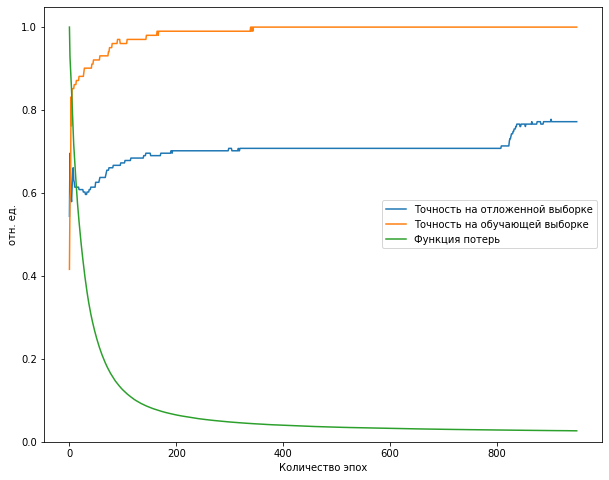

In [47]:
plt.figure(figsize=(10,8))
plt.plot(history_df.index, history_df['val_accuracy'], label='Точность на отложенной выборке')
plt.plot(history_df.index, history_df['accuracy'], label='Точность на обучающей выборке')
plt.plot(history_df.index, history_df['loss'], label='Функция потерь')
# plt.axvline(history_df.val_accuracy.idxmax(), label=history_df.val_accuracy.idxmax())
# plt.axvline(history_df.loss.idxmin(), label=history_df.loss.idxmin())
# plt.plot(history.index, history['loss'])
# plt.legend(['val_accuracy', 'accuracy', 'loss'])
plt.xlabel('Количество эпох')
plt.ylabel('отн. ед.')
plt.legend(loc='right')
plt.ylim(0)
plt.show()

In [39]:
y_pred = model.predict_classes(X_val)

In [40]:
f1_score(Y_val, y_pred, average='macro')

0.7853397612488523

In [41]:
accuracy_score(Y_val, y_pred)

0.7719298245614035

In [42]:
y_pred = model.predict_classes(X_val)
confusion_matrix(Y_val, y_pred)

array([[46,  4,  0],
       [ 0, 41, 35],
       [ 0,  0, 45]])

In [628]:
# model.save('best_model.h5')

## Short circuit test

In [654]:
X_test, labels_test = append_signals_np_array('./data/gen_4_80')
normalize_labels(labels_test)
Y_test = labels_test.label.values

In [655]:
y_pred = model.predict_classes(X_test)

In [657]:
Y_test

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [660]:
print('F1:', f1_score(Y_test, y_pred, average='macro'))
print('Accuracy', accuracy_score(Y_test, y_pred))
print('-' * 10)
confusion_matrix(Y_test, y_pred)

F1: 0.5764480581657659
Accuracy 0.6481481481481481
----------


array([[18,  0,  0],
       [11,  2,  8],
       [ 0,  0, 15]])

## Grid Search

In [125]:
f1 = dict()
acc = dict()

In [467]:
for i in range(60, 251, 10):
    model = Sequential()
    model.add(Dense(i, input_dim=n_0,
                    activation='relu',))
    model.add(Dense(n_4, activation='softmax'))
    optimizer = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, Y_train,
                    epochs=EPOCHS,
                    verbose=0,
                    validation_data=(X_val, Y_val)
                   )
    y_pred = model.predict_classes(X_val)
    f1[i] = f1_score(Y_val, y_pred, average='macro')
    acc[i] = accuracy_score(Y_val, y_pred)

In [468]:
def plot_grid_search(acc, f1):
    '''
    results - dict of searched values
    '''
    plt.figure(figsize=(8,6))
    x = acc.keys()
    acc = acc.values()
    f1 = f1.values()
    plt.plot(list(x), list(acc), 'rv-')
    plt.plot(list(x), list(f1), 'bs--')
    plt.xlabel('Количество нейронов в первом слое')
    plt.ylabel('Точность')
    plt.legend(['Средняя точность', 'Точность для класса'], loc='lower right')
    plt.show()

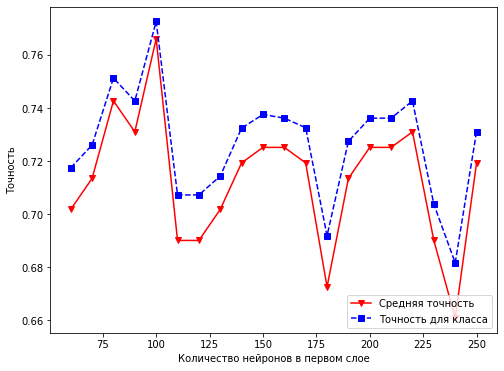

In [469]:
plot_grid_search(acc, f1)

In [470]:
acc[190]

0.7134502923976608

In [471]:
f1_n2 = dict()
acc_n2 = dict()

In [472]:
n_range = range(60, 161, 10)
for dropout_th in [0.5, 0.4, 0.3]:
    f1_n2[dropout_th] = dict()
    acc_n2[dropout_th] = dict()
    for i in n_range:
        model = Sequential()
        model.add(Dense(n_1, input_dim=n_0,
                        activation='relu',))
        model.add(Dense(i, activation='relu',))
        model.add(Dropout(dropout_th))
        model.add(Dense(n_4, activation='softmax'))
        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        model.fit(X_train, Y_train,
                        epochs=EPOCHS,
                        verbose=0,
                        validation_data=(X_val, Y_val)
                       )
        y_pred = model.predict_classes(X_val)
        f1_n2[dropout_th][i] = f1_score(Y_val, y_pred, average='macro')
        acc_n2[dropout_th][i] = accuracy_score(Y_val, y_pred)

In [473]:
print(f1, f1[0.5])

KeyError: 0.5

In [481]:
def plot_grid_search_n2(acc, f1):
    '''
    results - dict of searched values
    '''
    plt.figure(figsize=(8,6))
    legend = list()
    x = acc[list(acc.keys())[0]].keys()
    for dropout in acc:
        legend.append(f'Dropout {dropout}')
        plt.plot(list(x), list(acc[dropout].values()))
    plt.xlabel('Количество нейронов в первом слое')
    plt.ylabel('Точность')
    plt.legend(legend, loc='lower right')
    plt.show()

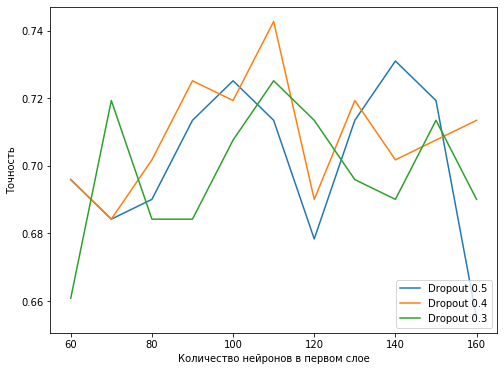

In [482]:
plot_grid_search_n2(acc_n2, f1_n2)